In [1]:
%config InlineBackend.figure_formats = ['svg']

import random
import quimb as qu
import quimb.tensor as qtn

N = 80
circ = qtn.Circuit(N)

# randomly permute the order of qubits
regs = list(range(N))
random.shuffle(regs)

# hamadard on one of the qubits
circ.apply_gate('H', regs[0])

# chain of cnots to generate GHZ-state
for i in range(N - 1):
    circ.apply_gate('CNOT', regs[i], regs[i + 1])

# sample it once
for b in circ.sample(1):
    print(b)

00000000000000000000000000000000000000000000000000000000000000000000000000000000


As mentioned above, various pre-processing steps need to occur (which will happen on the first run if not explicitly called). The results of these are cached such that the more you sample the more the simulation should speed up:

In [2]:
%%time
# sample it 8 times
for b in circ.sample(8):
    print(b)

00000000000000000000000000000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000000000000000000000000000
11111111111111111111111111111111111111111111111111111111111111111111111111111111
00000000000000000000000000000000000000000000000000000000000000000000000000000000
11111111111111111111111111111111111111111111111111111111111111111111111111111111
00000000000000000000000000000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000000000000000000000000000
11111111111111111111111111111111111111111111111111111111111111111111111111111111
CPU times: user 188 ms, sys: 149 µs, total: 188 ms
Wall time: 180 ms


Collect some statistics:

In [3]:
%%time
from collections import Counter

# sample it 100 times, count results:
Counter(circ.sample(100))

CPU times: user 195 ms, sys: 23 µs, total: 195 ms
Wall time: 193 ms


Counter({'00000000000000000000000000000000000000000000000000000000000000000000000000000000': 44,
         '11111111111111111111111111111111111111111111111111111111111111111111111111111111': 56})

In [4]:
# 10 qubits and tag the initial wavefunction tensors
circ = qtn.Circuit(N=10)

# initial layer of hadamards
for i in range(10):
    circ.apply_gate('H', i, gate_round=0)
    
# 8 rounds of entangling gates
for r in range(1, 9):
    
    # even pairs
    for i in range(0, 10, 2):
        circ.apply_gate('CNOT', i, i + 1, gate_round=r)

    # Y-rotations    
    for i in range(10):
        circ.apply_gate('RZ', 1.234, i, gate_round=r)
        
    # odd pairs
    for i in range(1, 9, 2):
        circ.apply_gate('CZ', i, i + 1, gate_round=r)
        
    # X-rotations    
    for i in range(10):
        circ.apply_gate('RX', 1.234, i, gate_round=r)
    
# final layer of hadamards
for i in range(10):
    circ.apply_gate('H', i, gate_round=r + 1)
    
circ

<Circuit(n=10, num_gates=252, gate_opts={'contract': 'auto-split-gate', 'propagate_tags': 'register'})>

The basic tensor network representing the state is stored in the 
``.psi`` attribute, which we can then visualize:

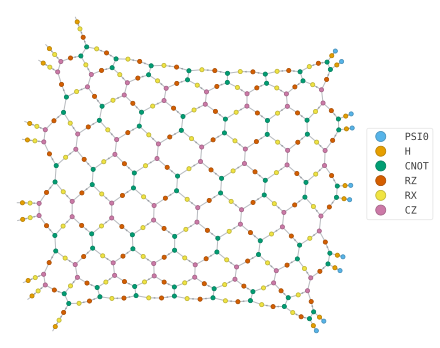

In [5]:
circ.psi.draw(color=['PSI0', 'H', 'CNOT', 'RZ', 'RX', 'CZ'])

Note by default the CNOT and CZ gates have
been split via a rank-2 spatial decomposition into two parts acting on each site seperately
but connected by a new bond. 
We can also graph the default (``propagate_tags='register'``) method for 
adding site tags to the applied operators:

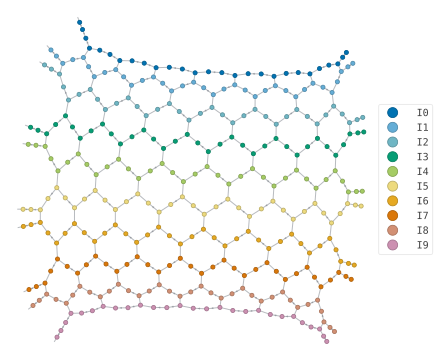

In [6]:
circ.psi.draw(color=[f'I{i}' for i in range(10)])

Or since we supplied ``gate_round`` as an keyword (which is optional), the tensors
are also tagged in that way:

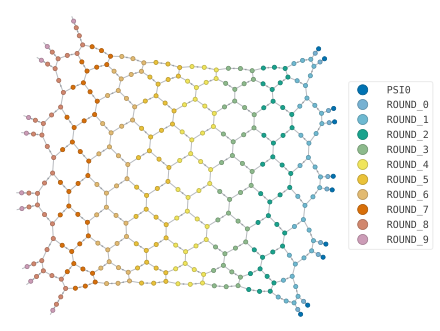

In [7]:
circ.psi.draw(color=['PSI0'] + [f'ROUND_{i}' for i in range(10)])

All of these might be helpful when addressing only certain tensors:

In [8]:
# select the subnetwork of tensors with *all* following tags
circ.psi.select(['CNOT', 'I3', 'ROUND_3'], which='all')

<TensorNetworkGenVector(tensors=1, indices=3)>

In [9]:
sorted(qtn.circuit.ALL_GATES)

['CNOT',
 'CU1',
 'CU2',
 'CU3',
 'CX',
 'CY',
 'CZ',
 'FS',
 'FSIM',
 'FSIMG',
 'H',
 'HZ_1_2',
 'IDEN',
 'IS',
 'ISWAP',
 'RX',
 'RY',
 'RZ',
 'RZZ',
 'S',
 'SU4',
 'SWAP',
 'T',
 'U1',
 'U2',
 'U3',
 'W_1_2',
 'X',
 'X_1_2',
 'Y',
 'Y_1_2',
 'Z',
 'Z_1_2']

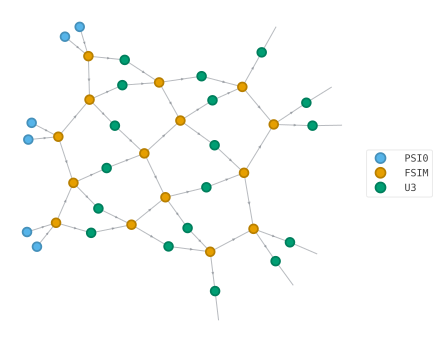

In [10]:
circ_param = qtn.Circuit(6)

for l in range(3):
    for i in range(0, 6, 2):
        circ_param.apply_gate('FSIM', random.random(), random.random(), i, i + 1, parametrize=True, contract=False)
    for i in range(1, 5, 2):
        circ_param.apply_gate('FSIM', random.random(), random.random(), i, i + 1, parametrize=True, contract=False)
    for i in range(6):
        circ_param.apply_gate('U3', random.random(), random.random(), random.random(), i, parametrize=True)
        
circ_param.psi.draw(color=['PSI0', 'FSIM', 'U3'])

We've used the ``contract=False`` option which doesn't try and split the gate tensor in any way,
so here there is now a single tensor per two qubit gate.
In fact, for ``'FSIM'`` and random parameters there is no low-rank decomposition that would happen
anyway, but this is also the only mode compatible with parametrized tensors:

In [11]:
circ_param.psi['GATE_0']

PTensor(shape=(2, 2, 2, 2), inds=('_0088d9AAGFn', '_0088d9AAGFj', '_0088d9AAGFd', '_0088d9AAGFe'), tags=oset(['GATE_0', 'FSIM', 'I0', 'I1']))

For most tasks like contraction these are transparently handled like normal tensors:

In [12]:
circ_param.amplitude('101001')

(-0.058090003639198556+0.05126407118612613j)

In [13]:
circ.amplitude('0101010101')

(-0.006267589645294012+0.012702244544177429j)

In [14]:
circ.local_expectation(qu.pauli('Z') & qu.pauli('Z'), (4, 5))

(-0.018188965185456173+8.673617379884035e-18j)

You can compute several individual expectations on the same sites by supplying a list (they are computed in a single contraction):

In [15]:
circ.local_expectation(
    [qu.pauli('X') & qu.pauli('X'),
     qu.pauli('Y') & qu.pauli('Y'),
     qu.pauli('Z') & qu.pauli('Z')], 
     where=(4, 5),
)

((-0.005784719259097466-1.8214596497756474e-17j),
 (0.058901881679242415+3.5561831257524545e-17j),
 (-0.018188965185456183+3.642919299551295e-17j))

In [16]:
circ.partial_trace((4, 5)).round(3)

array([[ 0.252-0.j   ,  0.013+0.011j, -0.019+0.007j, -0.016-0.003j],
       [ 0.013-0.011j,  0.255-0.j   ,  0.013+0.014j,  0.02 +0.017j],
       [-0.019-0.007j,  0.013-0.014j,  0.254-0.j   ,  0.019+0.012j],
       [-0.016+0.003j,  0.02 -0.017j,  0.019-0.012j,  0.239+0.j   ]])

In [17]:
p = circ.compute_marginal((1, 2), fix={0: '1', 3: '0', 4: '1'}, dtype='complex128')
p

array([[0.03422455, 0.02085596],
       [0.03080204, 0.02780321]])

In [18]:
qtn.circuit.sample_bitstring_from_prob_ndarray(p / p.sum())

'00'

In [19]:
for b in circ.sample(10, group_size=3):
    print(b)

1010000010
1010010001
1111111011
0011011101
1011010110
0010100011
1001110100
1110000000
0101110111
0110100101


In [20]:
for b in circ.sample_chaotic(10, marginal_qubits=5):
    print(b)

0001001100
1000111011
0100101100
1100001100
0000100110
0001100010
0101110100
0101010011
1010101101
0001101010


Five of these qubits will now be sampled completely randomly.

In [21]:
circ.to_dense()

[[ 0.022278+0.044826j]
 [ 0.047567+0.001852j]
 [-0.028239+0.01407j ]
 ...
 [ 0.016   -0.008447j]
 [-0.025437-0.015225j]
 [-0.033285-0.030653j]]

In [22]:
rehs = circ.amplitude_rehearse()

# contraction width
W = qu.log2(rehs['info'].largest_intermediate)
W

7.0

Upper twenties is the limit for standard (~10GB) amounts of RAM.

In [23]:
# contraction cost
# N.B.  raw .opt_cost assumes *real* dtype FLOPs
#       * 4  to get complex dtype FLOPs (relevant for most QC)
#       / 2  to get dtype independent scalar OPs (the 'cost')
C = qu.log10(rehs['info'].opt_cost / 2)  
C

3.9755237129603316

In [24]:
# perform contraction
rehs['tn'].contract(all, optimize=rehs['info'].path, output_inds=())

(0.01456793653391061+0.039229453534987115j)

In [25]:
rehs = circ.sample_rehearse(group_size=3)
rehs.keys()

dict_keys([(0, 1, 2), (3, 4, 9), (5, 6, 7), (8,)])

In [26]:
rehs[(3, 4, 9)].keys()

dict_keys(['tn', 'info', 'W', 'C'])

In [27]:
# just show the first 10...
lc_tags = circ.get_reverse_lightcone_tags(where=(0,))
lc_tags[:10]

('PSI0',
 'GATE_0',
 'GATE_1',
 'GATE_2',
 'GATE_3',
 'GATE_4',
 'GATE_5',
 'GATE_6',
 'GATE_7',
 'GATE_8')

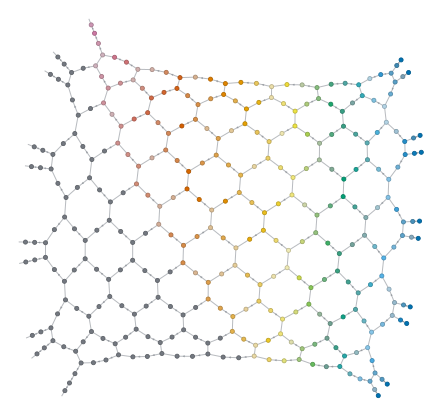

In [28]:
circ.psi.draw(color=lc_tags, legend=False)

We can plot the effect this has as selecting only these, $| \psi \rangle \rightarrow | \psi_{\bar{q}} \rangle$, on the norm with the following:

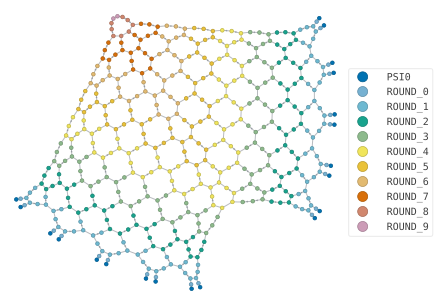

In [29]:
# get the reverse lightcone wavefunction of qubit 0
psi_q0 = circ.get_psi_reverse_lightcone(where=(0,))

# plot its norm
(psi_q0.H & psi_q0).draw(color=['PSI0'] + [f'ROUND_{i}' for i in range(10)])

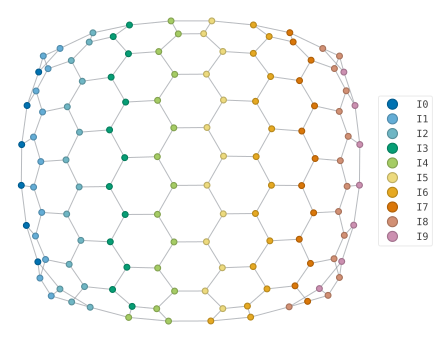

In [30]:
(
    circ
    # get the tensor network
    .amplitude_rehearse(simplify_sequence='R')['tn']
    # plot it with each qubit register highlighted
    .draw(color=[f'I{q}' for q in range(10)])
)

You can see that only 3+ dimensional tensors remain. Now if we turn on all the 
simplification methods we get an even smaller tensor network:

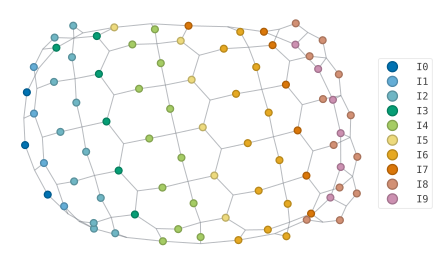

In [31]:
(
    circ
    # get the tensor network
    .amplitude_rehearse(simplify_sequence='ADCRS')['tn']
    # plot it with each qubit register highlighted
    .draw(color=[f'I{q}' for q in range(10)])
)

In [32]:
norm = circ.psi.H & circ.psi
norm

<TensorNetworkGen(tensors=668, indices=802)>

In [33]:
norm.full_simplify_(seq='ADCRS')

<TensorNetworkGen(tensors=87, indices=67)>

In [34]:
# we specify output_inds since we now have a hyper tensor network
norm.contract(..., output_inds=())

(0.9999999999999558+5.551115123125783e-17j)

In [35]:
# compute the ZZ correlation on qubits 3 & 4
ZZ = qu.pauli('Z') & qu.pauli('Z')
where = (3, 4)

In [36]:
rehs = circ.local_expectation_rehearse(ZZ, where, optimize='greedy')
tn, info = rehs['tn'], rehs['info']
info.opt_cost

Decimal('264240')

In [37]:
%%timeit
circ.local_expectation(ZZ, where, optimize='greedy')

26.9 ms ± 740 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


We can compare this to just performing the main contraction:

In [38]:
%%timeit
tn.contract(all, optimize=info.path, output_inds=())

3.61 ms ± 88.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
import opt_einsum as oe

# up the number of repeats and make it run in parallel
opt_rg = oe.RandomGreedy(max_repeats=256, parallel=True)

rehs = circ.local_expectation_rehearse(ZZ, where, optimize=opt_rg)
tn, info = rehs['tn'], rehs['info']
info.opt_cost

Decimal('152176')

We see it has found a much better path than ``'greedy'``, which is not so surprising.

Unlike before, if we want to reuse the path found from this, we can directly access the ``.path`` 
attribute from the ``info`` object (or the `PathOptimizer` object):

In [40]:
%%timeit
circ.local_expectation(ZZ, where, optimize=info.path)

26.7 ms ± 629 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
import cotengra as ctg

# the kwargs ReusableHyperOptimizer take are the same as HyperOptimizer
opt = ctg.ReusableHyperOptimizer(
    max_repeats=16, 
    reconf_opts={},
    parallel=False,
    progbar=True,
#     directory='ctg_path_cache',  # if you want a persistent path cache
)

rehs = circ.local_expectation_rehearse(ZZ, where, optimize=opt)
tn, info = rehs['tn'], rehs['info']
info.opt_cost

log2[SIZE]: 10.00 log10[FLOPs]: 4.93: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


Decimal('84588')

We can see even for this small contraction it has improved on the ``RandomGreedy`` path cost.
We could use ``info.path`` here but since we have a ``ReusableHyperOptimizer`` path 
optimizer, this second time its called on the same contraction it will simply get
the path from its cache anway:

In [42]:
%%timeit
circ.local_expectation(ZZ, where, optimize=opt)

26.8 ms ± 624 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Again, since the main contraction is very small, we don't see any real improvement.

``cotengra`` also has a ``ContractionTree`` object for manipulating and visualizing
the contraction paths found.

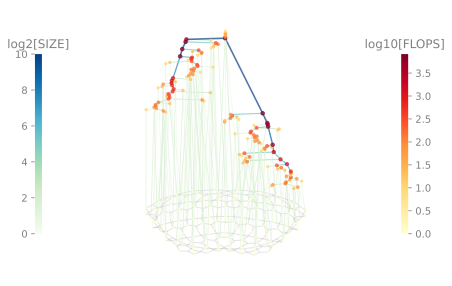

In [43]:
tree = ctg.ContractionTree.from_info(info)
tree.plot_tent(order=True)

Here the, grey network at the bottom is the TN to be contracted, and the tree
above it depicts the series of pairwise contractions and their individual cost
needed to find the output answer (the node at the top).

In [44]:
{t.size for t in tn}

{2, 4, 8}

When it comes to the actual contraction however, where large tensors will appear, it can be advantageous to
use a different library to perform the contractions. If you specify a ``backend`` kwarg, before contraction,
the arrays will converted to the ``backend``, then the contraction performed, and the result converted back
to ``numpy``. 
[The list of available backends is here](https://optimized-einsum.readthedocs.io/en/stable/backends.html#special-gpu-backends-for-numpy-arrays), including:


* `cupy`
* `jax` (note this actively defaults to single precision)
* `torch`
* `tensorflow`

Sampling is an excellent candidate for GPU acceleration as the same geometry TNs
are contracted over and over again and since sampling is inherently a low 
precision task, single precision arrays are a natural fit.

In [45]:
for b in circ.sample(10, backend='jax', dtype='complex64'):
    print(b)

0101000100
0111100001
0001111010
0011001111
0111010010
1111000011
1010111000
1001100000
0010101101
1110000101
